#**KLASIFIKASI MULTILABEL BATIK BESUREK BENGKULU**

#**Data Loading dan Library**

### Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Import Library

In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.metrics import AUC


### Path Dataset

In [ ]:
# Path dataset
train_csv_path = "/content/drive/MyDrive/Dataset/DataNA/train/_classes.csv"
test_csv_path = "/content/drive/MyDrive/Dataset/DataNA/test/_classes.csv"
valid_csv_path = "/content/drive/MyDrive/Dataset/DataNA/valid/_classes.csv"

# folder image dataset
train_img_folder = "/content/drive/MyDrive/Dataset/DataNA/train"
test_img_folder = "/content/drive/MyDrive/Dataset/DataNA/test"
valid_img_folder = "/content/drive/MyDrive/Dataset/DataNA/valid"

# Load CSV
train_df = pd.read_csv(train_csv_path)
test_df = pd.read_csv(test_csv_path)
valid_df = pd.read_csv(valid_csv_path)

# Validasi file gambar (hapus file yang tidak ada di folder)
train_df = train_df[train_df['filename'].apply(lambda x: os.path.exists(os.path.join(train_img_folder, x)))]
test_df = test_df[test_df['filename'].apply(lambda x: os.path.exists(os.path.join(test_img_folder, x)))]
valid_df = valid_df[valid_df['filename'].apply(lambda x: os.path.exists(os.path.join(valid_img_folder, x)))]


# **Data Understanding**


### Total Jumlah Data Train dan Test


In [ ]:
print("Total gambar Train yang valid:", len(train_df))
print("Total gambar Val yang valid:", len(valid_df))
print("Total gambar Test yang valid:", len(test_df))

Total gambar Train yang valid: 6633
Total gambar Val yang valid: 1894
Total gambar Test yang valid: 947


In [ ]:
# Tampilkan 5 baris pertama dari train_df
train_df.head()


filename  Burung Kuau  \
0  IMG_6110_jpeg_jpg.rf.9d4b86164acf2c21dbdc839e0...            0   
1  20241030_154906-1-_jpg.rf.650c2e3cfec4af28672f...            1   
2  IMG_20250107_143713_jpg.rf.7e1285ab5930922b64e...            0   
3  IMG_6115_jpeg_jpg.rf.dfbb8407f8a92e602bedbc1e2...            0   
4  20241030_144301_jpg.rf.4c2fe5457ca5bac45387f01...            0   

   Burung Punai  Kaligrafi  Kaligrafi Lawas  Kembang Cempaka  Kembang Cengkeh  \
0             1          1                0                0                0   
1             0          1                0                0                0   
2             0          1                0                0                0   
3             1          1                0                0                0   
4             0          1                0                0                0   

   Kembang Melati  Pohon Hayat  Rafflesia  Relung Paku  Rembulan  
0               0            0          0            1         0  
1               0            0          0            0         0  
2               0            0          0            0         1  
3               0            0          0            1         0  
4               1            0          0            0         0

### Jumlah Data di Setiap Label

In [ ]:
print("Distribusi Label Train:")
print(train_df.iloc[:, 1:].sum())

print("\nDistribusi Label Valid:")
print(valid_df.iloc[:, 1:].sum())

print("\nDistribusi Label Test:")
print(test_df.iloc[:, 1:].sum())


Distribusi Label Train:
Burung Kuau        1658
Burung Punai        830
Kaligrafi          4975
Kaligrafi Lawas     829
Kembang Cempaka     829
Kembang Cengkeh     829
Kembang Melati      829
Pohon Hayat         829
Rafflesia           829
Relung Paku         830
Rembulan            829
dtype: int64

Distribusi Label Valid:
Burung Kuau         462
Burung Punai        225
Kaligrafi          1402
Kaligrafi Lawas     244
Kembang Cempaka     235
Kembang Cengkeh     235
Kembang Melati      239
Pohon Hayat         232
Rafflesia           248
Relung Paku         225
Rembulan            241
dtype: int64

Distribusi Label Test:
Burung Kuau        232
Burung Punai       112
Kaligrafi          701
Kaligrafi Lawas    122
Kembang Cempaka    117
Kembang Cengkeh    117
Kembang Melati     119
Pohon Hayat        116
Rafflesia          124
Relung Paku        112
Rembulan           121
dtype: int64


In [ ]:
import pandas as pd

# Menghitung jumlah sampel per label di setiap dataset
train_label_counts = train_df.iloc[:, 1:].sum()
valid_label_counts = valid_df.iloc[:, 1:].sum()
test_label_counts = test_df.iloc[:, 1:].sum()

# Membuat DataFrame untuk tampilan tabel
label_distribution_df = pd.DataFrame({
    "Train": train_label_counts,
    "Valid": valid_label_counts,
    "Test": test_label_counts,
    "Total": train_label_counts + valid_label_counts + test_label_counts  # Menambahkan kolom total
})

# Menampilkan tabel dengan format rapi
print("\n=== Distribusi Label di Dataset ===")
print(label_distribution_df)



=== Distribusi Label di Dataset ===
                 Train  Valid  Test  Total
Burung Kuau       1658    462   232   2352
Burung Punai       830    225   112   1167
Kaligrafi         4975   1402   701   7078
Kaligrafi Lawas    829    244   122   1195
Kembang Cempaka    829    235   117   1181
Kembang Cengkeh    829    235   117   1181
Kembang Melati     829    239   119   1187
Pohon Hayat        829    232   116   1177
Rafflesia          829    248   124   1201
Relung Paku        830    225   112   1167
Rembulan           829    241   121   1191


### Grafik Distribusi Label

<ipython-input-8-3249943042>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(y='Label Combination', x='Count', data=combo_counts, palette='magma')


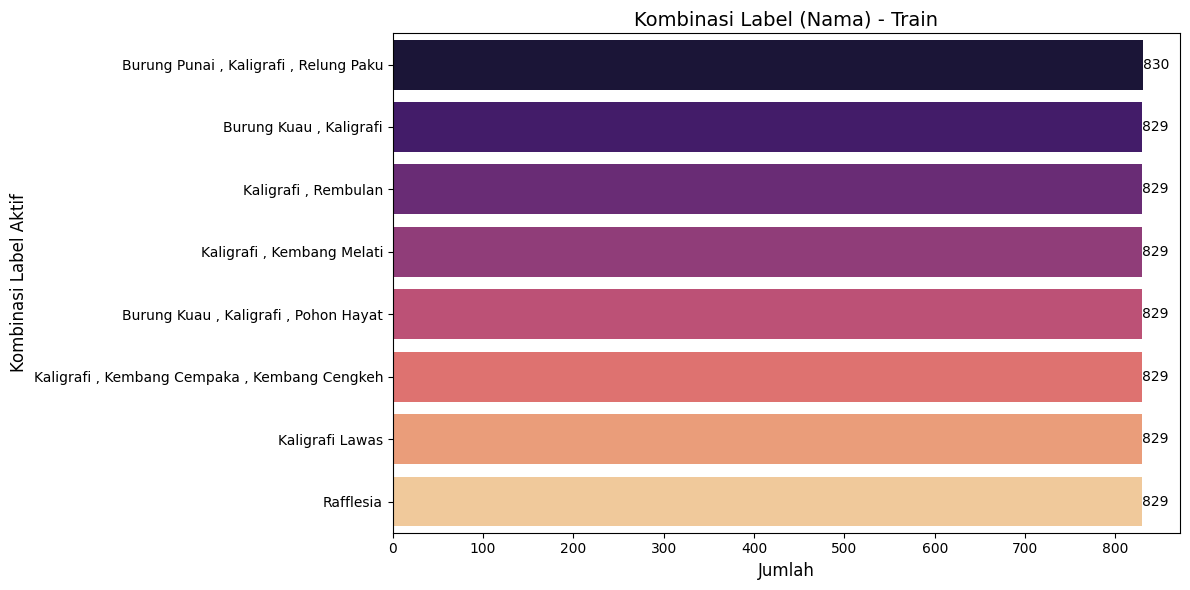

<ipython-input-8-3249943042>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(y='Label Combination', x='Count', data=combo_counts, palette='magma')


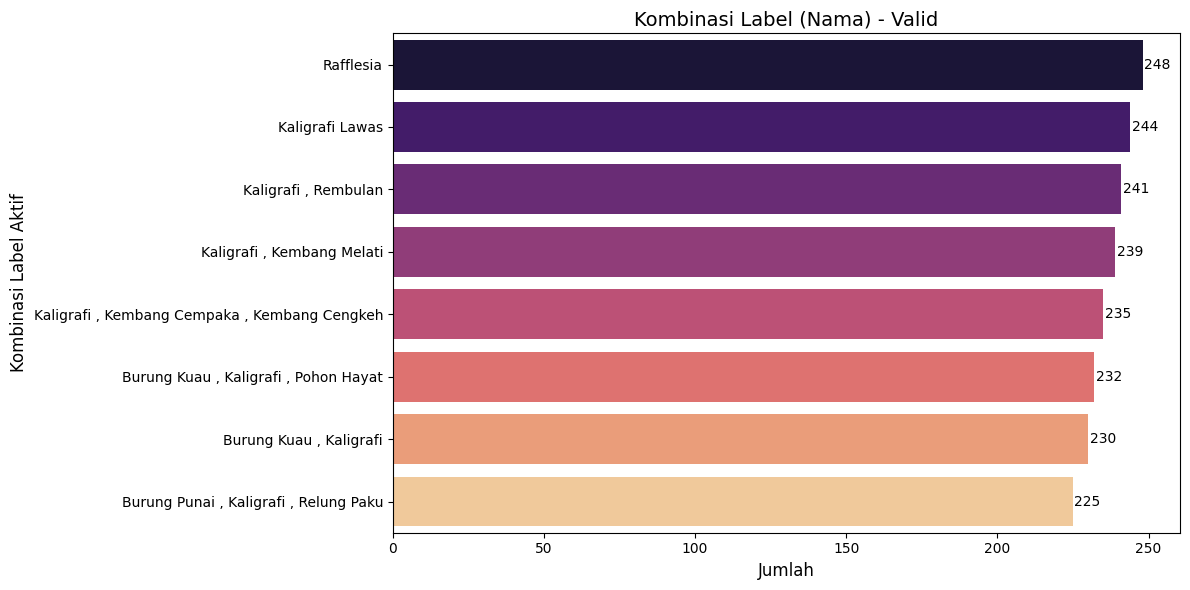

<ipython-input-8-3249943042>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(y='Label Combination', x='Count', data=combo_counts, palette='magma')


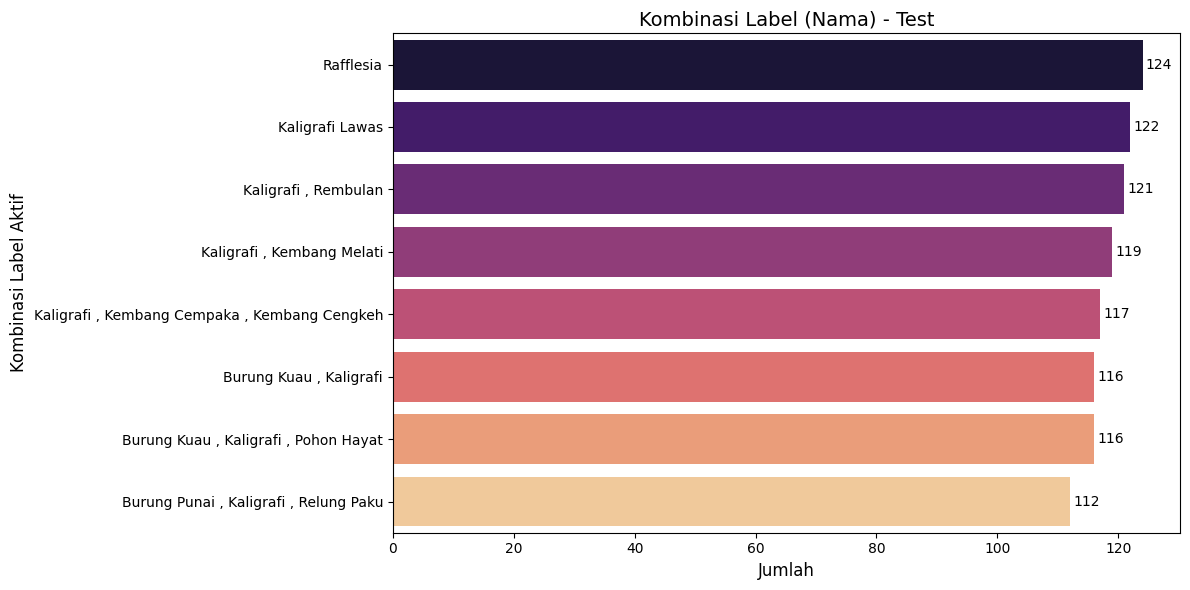

In [ ]:
# Fungsi ambil kombinasi label pakai nama label
def get_named_label_combinations(df):
    label_cols = df.columns[1:]  # Ambil semua kolom label
    def combo_to_names(row):
        return ' , '.join([label for label, val in zip(label_cols, row) if val == 1]) or 'No Label'

    combos = df[label_cols].apply(combo_to_names, axis=1)
    combo_counts = combos.value_counts().reset_index()
    combo_counts.columns = ['Label Combination', 'Count']
    return combo_counts

# Fungsi buat plot + label jumlah
def plot_combinations(combo_counts, dataset_name):
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(y='Label Combination', x='Count', data=combo_counts, palette='magma')
    plt.title(f'Kombinasi Label (Nama) - {dataset_name}', fontsize=14)
    plt.xlabel('Jumlah', fontsize=12)
    plt.ylabel('Kombinasi Label Aktif', fontsize=12)

    # Tambahkan teks jumlah di ujung bar
    for i, (count) in enumerate(combo_counts['Count']):
        ax.text(count + 0.5, i, str(count), color='black', va='center', fontsize=10)

    plt.tight_layout()
    plt.show()

# Load dan filter ulang seperti biasa
train_df = pd.read_csv(train_csv_path)
test_df = pd.read_csv(test_csv_path)
valid_df = pd.read_csv(valid_csv_path)

train_df = train_df[train_df['filename'].apply(lambda x: os.path.exists(os.path.join(train_img_folder, x)))]
test_df = test_df[test_df['filename'].apply(lambda x: os.path.exists(os.path.join(test_img_folder, x)))]
valid_df = valid_df[valid_df['filename'].apply(lambda x: os.path.exists(os.path.join(valid_img_folder, x)))]

# Plot kombinasi label (dengan nama & jumlah) untuk tiap dataset
plot_combinations(get_named_label_combinations(train_df), "Train")
plot_combinations(get_named_label_combinations(valid_df), "Valid")
plot_combinations(get_named_label_combinations(test_df), "Test")


### Sampel Gambar dan Label

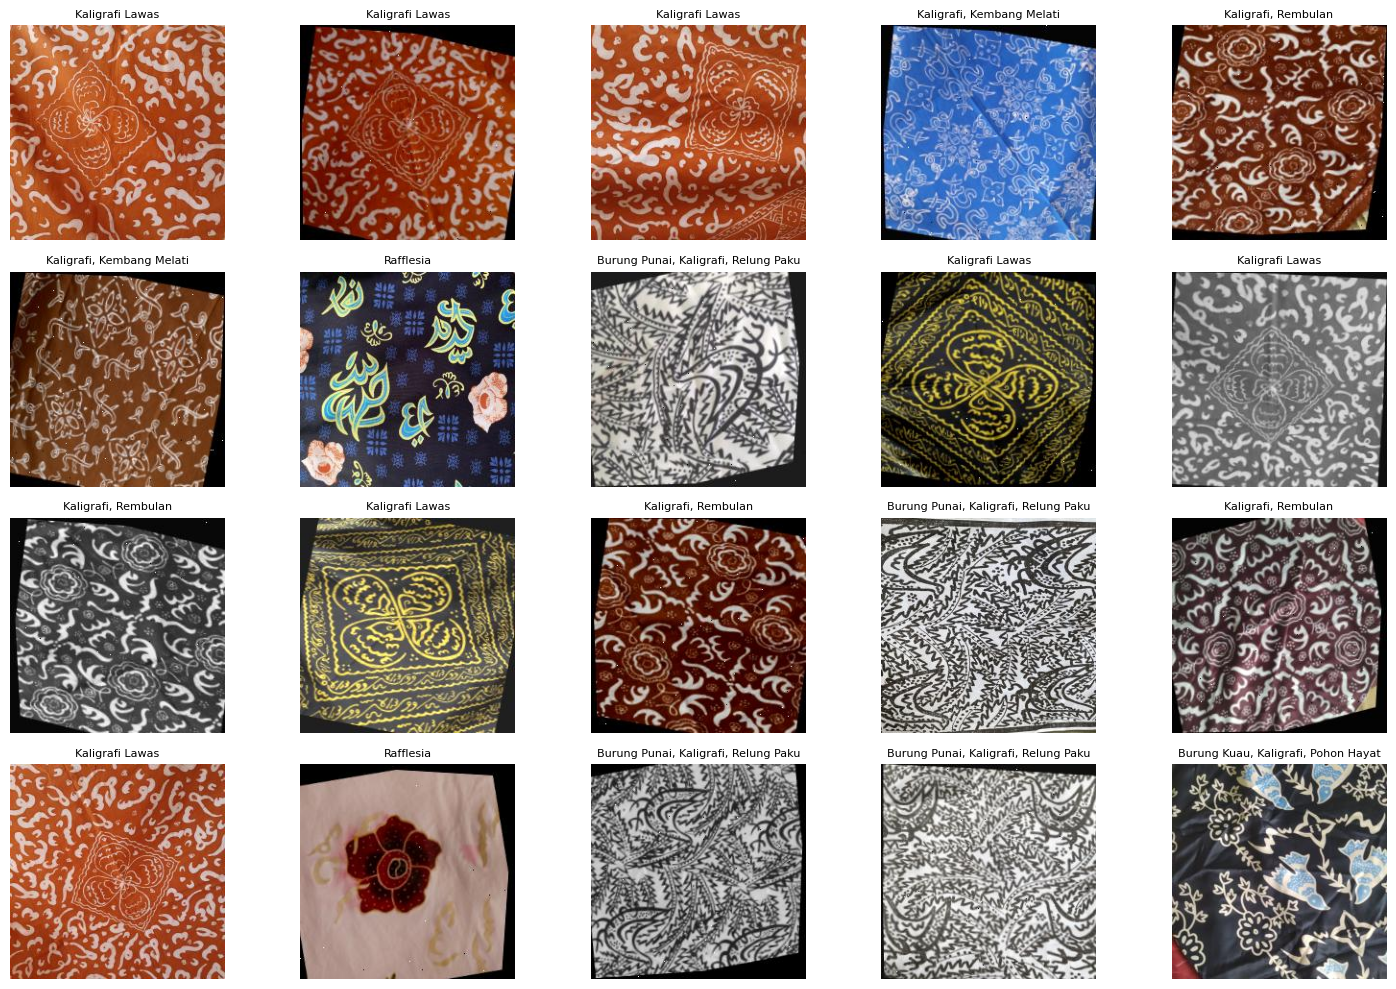

In [ ]:
from PIL import Image


# Fungsi untuk konversi row label jadi teks label
def get_labels(row, label_cols):
    return ', '.join([label for label in label_cols if row[label] == 1]) or 'No Label'

# Ambil 20 sampel acak dari train_df
sample_df = train_df.sample(n=20, random_state=42).reset_index(drop=True)
label_cols = train_df.columns[1:]

# Plot gambar
plt.figure(figsize=(15, 10))
for i in range(20):
    img_path = os.path.join(train_img_folder, sample_df.loc[i, 'filename'])
    img = Image.open(img_path).convert('RGB')

    plt.subplot(4, 5, i+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(get_labels(sample_df.loc[i], label_cols), fontsize=8)

plt.tight_layout()
plt.show()


# **Data Preparation**

### Augmentasi Data Train

In [ ]:
label_columns = train_df.columns[1:].tolist()

image_size = (224, 224)
batch_size = 32

# Normalisasi data
datagen = ImageDataGenerator(rescale=1.0 / 255)

### Data Generator



In [ ]:
# Train generator
train_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=train_img_folder,
    x_col='filename',
    y_col=label_columns,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='raw',
    shuffle=True,
)

# Validation generator
valid_generator = datagen.flow_from_dataframe(
    dataframe=valid_df,
    directory=valid_img_folder,
    x_col='filename',
    y_col=label_columns,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='raw',
    shuffle=False
)

# Test generator
test_generator = datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=test_img_folder,
    x_col='filename',
    y_col=label_columns,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='raw',
    shuffle=False
)

Found 2879 validated image filenames.
Found 823 validated image filenames.
Found 412 validated image filenames.


In [ ]:
# Ambil satu batch sample dari train_generator
x_batch, y_batch = next(train_generator)

# Cek shape input dan label
print(f"Shape input batch: {x_batch.shape}")  # Harusnya (batch_size, 224, 224, 3)
print(f"Shape label batch: {y_batch.shape}")  # Harusnya (batch_size, jumlah_kelas)

Shape input batch: (32, 224, 224, 3)
Shape label batch: (32, 11)


# **Modeling**

### Pembuatan Model

In [ ]:
from tensorflow.keras.applications import MobileNetV2

# Load MobileNetV2 tanpa fully connected layer atas (include_top=False)
base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Freeze semua layer di MobileNetV2 agar hanya bagian atas yang dilatih
base_model.trainable = False

# Custom head untuk multi-label classification
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.5)(x)
output = Dense(11, activation='sigmoid')(x)  # Multi-label classification

# Gabungkan base model + custom head
model = Model(inputs=base_model.input, outputs=output)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


### Compile Model

In [ ]:
# Path penyimpanan model di Google Drive
best_model_path = "/content/drive/MyDrive/Dataset/MobileNetV2_3.h5"

# Compile model dengan optimizer Adam dan AUC sebagai metric
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss="binary_crossentropy",
    metrics=[tf.keras.metrics.AUC(name="auc")]
)

# Callbacks untuk early stopping, learning rate reduction, dan model checkpoint
callbacks = [
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-7),
    ModelCheckpoint(best_model_path, save_best_only=True, monitor="val_loss", mode="min")
]

# Tampilkan arsitektur model
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,272,075 (8.67 MB)

 Trainable params: 14,091 (55.04 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

### Train Model

In [ ]:
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=30,
    callbacks=callbacks
)
#12.11 am - 1.09 am

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 23s/step - auc: 0.5549 - loss: 0.7712 

90/90 ━━━━━━━━━━━━━━━━━━━━ 2779s 31s/step - auc: 0.5556 - loss: 0.7697 - val_auc: 0.7337 - val_loss: 0.4102 - learning_rate: 1.0000e-04
Epoch 2/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - auc: 0.7287 - loss: 0.4499

90/90 ━━━━━━━━━━━━━━━━━━━━ 16s 181ms/step - auc: 0.7290 - loss: 0.4497 - val_auc: 0.8863 - val_loss: 0.3230 - learning_rate: 1.0000e-04
Epoch 3/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - auc: 0.8281 - loss: 0.3540

90/90 ━━━━━━━━━━━━━━━━━━━━ 17s 187ms/step - auc: 0.8283 - loss: 0.3538 - val_auc: 0.9485 - val_loss: 0.2587 - learning_rate: 1.0000e-04
Epoch 4/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - auc: 0.8966 - loss: 0.2903

90/90 ━━━━━━━━━━━━━━━━━━━━ 19s 211ms/step - auc: 0.8967 - loss: 0.2902 - val_auc: 0.9738 - val_loss: 0.2113 - learning_rate: 1.0000e-04
Epoch 5/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - auc: 0.9307 - loss: 0.2478

90/90 ━━━━━━━━━━━━━━━━━━━━ 19s 213ms/step - auc: 0.9308 - loss: 0.2476 - val_auc: 0.9848 - val_loss: 0.1761 - learning_rate: 1.0000e-04
Epoch 6/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - auc: 0.9592 - loss: 0.2051

90/90 ━━━━━━━━━━━━━━━━━━━━ 17s 188ms/step - auc: 0.9592 - loss: 0.2050 - val_auc: 0.9908 - val_loss: 0.1497 - learning_rate: 1.0000e-04
Epoch 7/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - auc: 0.9713 - loss: 0.1777

90/90 ━━━━━━━━━━━━━━━━━━━━ 17s 194ms/step - auc: 0.9714 - loss: 0.1776 - val_auc: 0.9939 - val_loss: 0.1295 - learning_rate: 1.0000e-04
Epoch 8/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - auc: 0.9790 - loss: 0.1610

90/90 ━━━━━━━━━━━━━━━━━━━━ 17s 187ms/step - auc: 0.9791 - loss: 0.1609 - val_auc: 0.9960 - val_loss: 0.1128 - learning_rate: 1.0000e-04
Epoch 9/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - auc: 0.9859 - loss: 0.1386

90/90 ━━━━━━━━━━━━━━━━━━━━ 17s 187ms/step - auc: 0.9859 - loss: 0.1386 - val_auc: 0.9971 - val_loss: 0.0998 - learning_rate: 1.0000e-04
Epoch 10/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - auc: 0.9905 - loss: 0.1215

90/90 ━━━━━━━━━━━━━━━━━━━━ 19s 206ms/step - auc: 0.9905 - loss: 0.1215 - val_auc: 0.9979 - val_loss: 0.0891 - learning_rate: 1.0000e-04
Epoch 11/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - auc: 0.9920 - loss: 0.1120

90/90 ━━━━━━━━━━━━━━━━━━━━ 18s 183ms/step - auc: 0.9920 - loss: 0.1119 - val_auc: 0.9983 - val_loss: 0.0802 - learning_rate: 1.0000e-04
Epoch 12/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - auc: 0.9946 - loss: 0.0999

90/90 ━━━━━━━━━━━━━━━━━━━━ 17s 187ms/step - auc: 0.9946 - loss: 0.0999 - val_auc: 0.9985 - val_loss: 0.0729 - learning_rate: 1.0000e-04
Epoch 13/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - auc: 0.9955 - loss: 0.0888

90/90 ━━━━━━━━━━━━━━━━━━━━ 18s 203ms/step - auc: 0.9955 - loss: 0.0888 - val_auc: 0.9988 - val_loss: 0.0666 - learning_rate: 1.0000e-04
Epoch 14/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - auc: 0.9960 - loss: 0.0853

90/90 ━━━━━━━━━━━━━━━━━━━━ 19s 211ms/step - auc: 0.9960 - loss: 0.0853 - val_auc: 0.9989 - val_loss: 0.0610 - learning_rate: 1.0000e-04
Epoch 15/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - auc: 0.9970 - loss: 0.0778

90/90 ━━━━━━━━━━━━━━━━━━━━ 19s 211ms/step - auc: 0.9970 - loss: 0.0778 - val_auc: 0.9990 - val_loss: 0.0563 - learning_rate: 1.0000e-04
Epoch 16/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - auc: 0.9980 - loss: 0.0719

90/90 ━━━━━━━━━━━━━━━━━━━━ 16s 180ms/step - auc: 0.9980 - loss: 0.0718 - val_auc: 0.9990 - val_loss: 0.0522 - learning_rate: 1.0000e-04
Epoch 17/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - auc: 0.9982 - loss: 0.0667

90/90 ━━━━━━━━━━━━━━━━━━━━ 17s 186ms/step - auc: 0.9982 - loss: 0.0666 - val_auc: 0.9992 - val_loss: 0.0484 - learning_rate: 1.0000e-04
Epoch 18/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - auc: 0.9981 - loss: 0.0620

90/90 ━━━━━━━━━━━━━━━━━━━━ 17s 189ms/step - auc: 0.9981 - loss: 0.0620 - val_auc: 0.9992 - val_loss: 0.0454 - learning_rate: 1.0000e-04
Epoch 19/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - auc: 0.9982 - loss: 0.0600

90/90 ━━━━━━━━━━━━━━━━━━━━ 17s 186ms/step - auc: 0.9982 - loss: 0.0600 - val_auc: 0.9992 - val_loss: 0.0426 - learning_rate: 1.0000e-04
Epoch 20/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - auc: 0.9982 - loss: 0.0572

90/90 ━━━━━━━━━━━━━━━━━━━━ 17s 183ms/step - auc: 0.9982 - loss: 0.0572 - val_auc: 0.9992 - val_loss: 0.0400 - learning_rate: 1.0000e-04
Epoch 21/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - auc: 0.9989 - loss: 0.0499

90/90 ━━━━━━━━━━━━━━━━━━━━ 17s 184ms/step - auc: 0.9989 - loss: 0.0499 - val_auc: 0.9993 - val_loss: 0.0377 - learning_rate: 1.0000e-04
Epoch 22/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - auc: 0.9990 - loss: 0.0488

90/90 ━━━━━━━━━━━━━━━━━━━━ 16s 183ms/step - auc: 0.9990 - loss: 0.0488 - val_auc: 0.9993 - val_loss: 0.0356 - learning_rate: 1.0000e-04
Epoch 23/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - auc: 0.9990 - loss: 0.0459

90/90 ━━━━━━━━━━━━━━━━━━━━ 18s 202ms/step - auc: 0.9991 - loss: 0.0459 - val_auc: 0.9993 - val_loss: 0.0337 - learning_rate: 1.0000e-04
Epoch 24/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - auc: 0.9990 - loss: 0.0450

90/90 ━━━━━━━━━━━━━━━━━━━━ 16s 182ms/step - auc: 0.9990 - loss: 0.0450 - val_auc: 0.9993 - val_loss: 0.0320 - learning_rate: 1.0000e-04
Epoch 25/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - auc: 0.9991 - loss: 0.0419

90/90 ━━━━━━━━━━━━━━━━━━━━ 16s 183ms/step - auc: 0.9991 - loss: 0.0419 - val_auc: 0.9993 - val_loss: 0.0304 - learning_rate: 1.0000e-04
Epoch 26/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - auc: 0.9994 - loss: 0.0404

90/90 ━━━━━━━━━━━━━━━━━━━━ 18s 198ms/step - auc: 0.9994 - loss: 0.0404 - val_auc: 0.9994 - val_loss: 0.0290 - learning_rate: 1.0000e-04
Epoch 27/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - auc: 0.9995 - loss: 0.0375

90/90 ━━━━━━━━━━━━━━━━━━━━ 17s 186ms/step - auc: 0.9995 - loss: 0.0375 - val_auc: 0.9993 - val_loss: 0.0277 - learning_rate: 1.0000e-04
Epoch 28/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - auc: 0.9993 - loss: 0.0361

90/90 ━━━━━━━━━━━━━━━━━━━━ 17s 185ms/step - auc: 0.9993 - loss: 0.0361 - val_auc: 0.9994 - val_loss: 0.0265 - learning_rate: 1.0000e-04
Epoch 29/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - auc: 0.9993 - loss: 0.0349

90/90 ━━━━━━━━━━━━━━━━━━━━ 16s 180ms/step - auc: 0.9993 - loss: 0.0349 - val_auc: 0.9994 - val_loss: 0.0254 - learning_rate: 1.0000e-04
Epoch 30/30
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - auc: 0.9996 - loss: 0.0318

90/90 ━━━━━━━━━━━━━━━━━━━━ 17s 184ms/step - auc: 0.9996 - loss: 0.0318 - val_auc: 0.9994 - val_loss: 0.0244 - learning_rate: 1.0000e-04


### Plotting

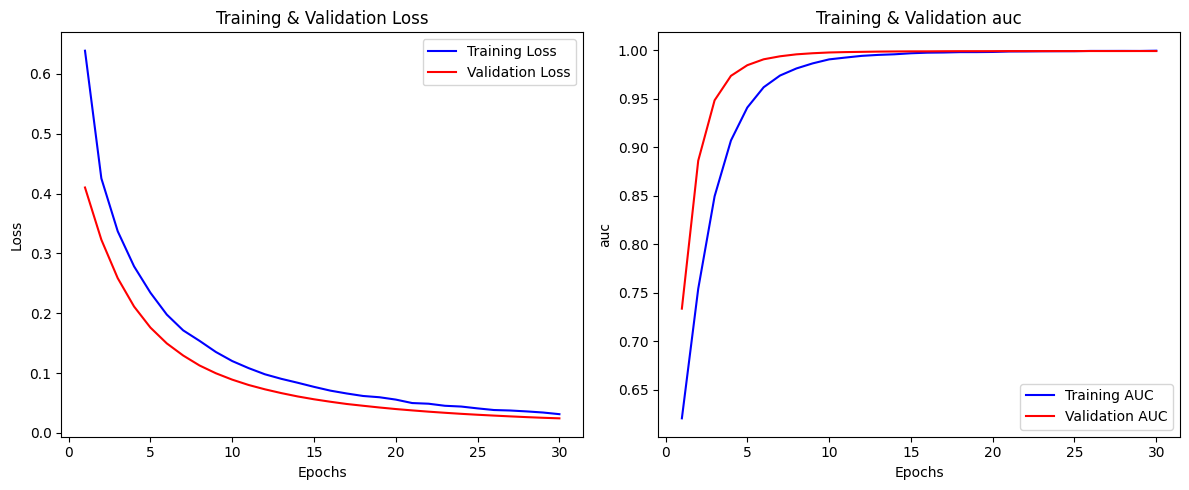

In [ ]:
# Ambil data dari history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_auc = history.history['auc']
val_auc = history.history['val_auc']

epochs = range(1, len(train_loss) + 1)

# Plot Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()

# Plot AUC
plt.subplot(1, 2, 2)
plt.plot(epochs, train_auc, 'b-', label='Training AUC')
plt.plot(epochs, val_auc, 'r-', label='Validation AUC')
plt.xlabel('Epochs')
plt.ylabel('auc')
plt.title('Training & Validation auc')
plt.legend()

plt.tight_layout()
plt.show()


# **Evaluasi**

### Prediksi dengan test set

In [ ]:
# Load model
best_model_path = "/content/drive/MyDrive/Dataset/MobileNetV2_3.h5"
model = tf.keras.models.load_model(best_model_path)

# Prediksi pada test set
y_pred_prob = model.predict(test_generator)
y_pred = (y_pred_prob > 0.5).astype(int)

test_loss, test_auc = model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test AUC: {test_auc:.4f}")


13/13 ━━━━━━━━━━━━━━━━━━━━ 298s 25s/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 8s 379ms/step - auc: 1.0000 - loss: 0.0202
Test Loss: 0.0211
Test AUC: 1.0000


### Classification Report

In [ ]:
# Ambil label asli
y_true = test_df.iloc[:, 1:].values  # Mengambil nilai label dari dataframe
labels = test_df.columns[1:].tolist()

# Classification Report
print(classification_report(y_true, y_pred, target_names=labels))


                 precision    recall  f1-score   support

    Burung Kuau       1.00      0.97      0.99       107
   Burung Punai       1.00      1.00      1.00        43
      Kaligrafi       1.00      1.00      1.00       313
Kaligrafi Lawas       1.00      0.98      0.99        52
Kembang Cempaka       1.00      1.00      1.00        57
Kembang Cengkeh       1.00      1.00      1.00        57
 Kembang Melati       1.00      0.96      0.98        54
    Pohon Hayat       1.00      1.00      1.00        55
      Rafflesia       1.00      0.96      0.98        47
    Relung Paku       1.00      1.00      1.00        43
       Rembulan       1.00      0.96      0.98        52

      micro avg       1.00      0.99      0.99       880
      macro avg       1.00      0.98      0.99       880
   weighted avg       1.00      0.99      0.99       880
    samples avg       0.99      0.99      0.99       880



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Confussion Matrix

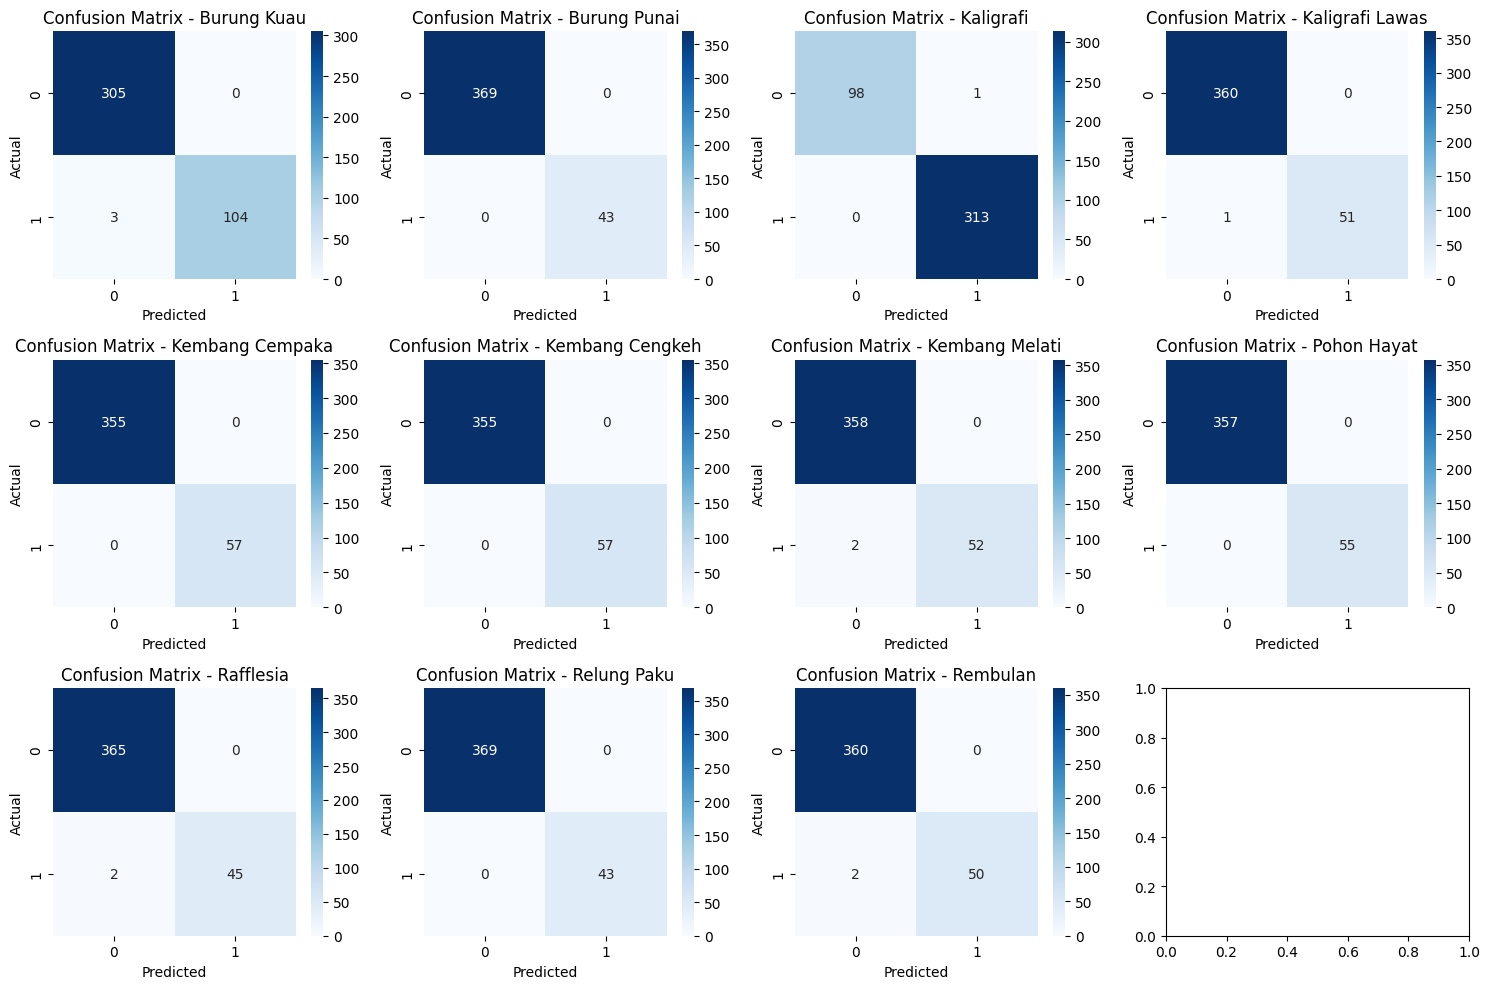

In [ ]:
# Cell 3: Confusion Matrix per Label
from sklearn.metrics import classification_report, multilabel_confusion_matrix

cm_list = multilabel_confusion_matrix(y_true, y_pred)
fig, axes = plt.subplots(3, 4, figsize=(15, 10))
axes = axes.ravel()

for i, (label, cm) in enumerate(zip(labels, cm_list)):
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=axes[i])
    axes[i].set_title(f'Confusion Matrix - {label}')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')

plt.tight_layout()
plt.show()


### Menampilkan Gambar dengan Label dan Prediksi

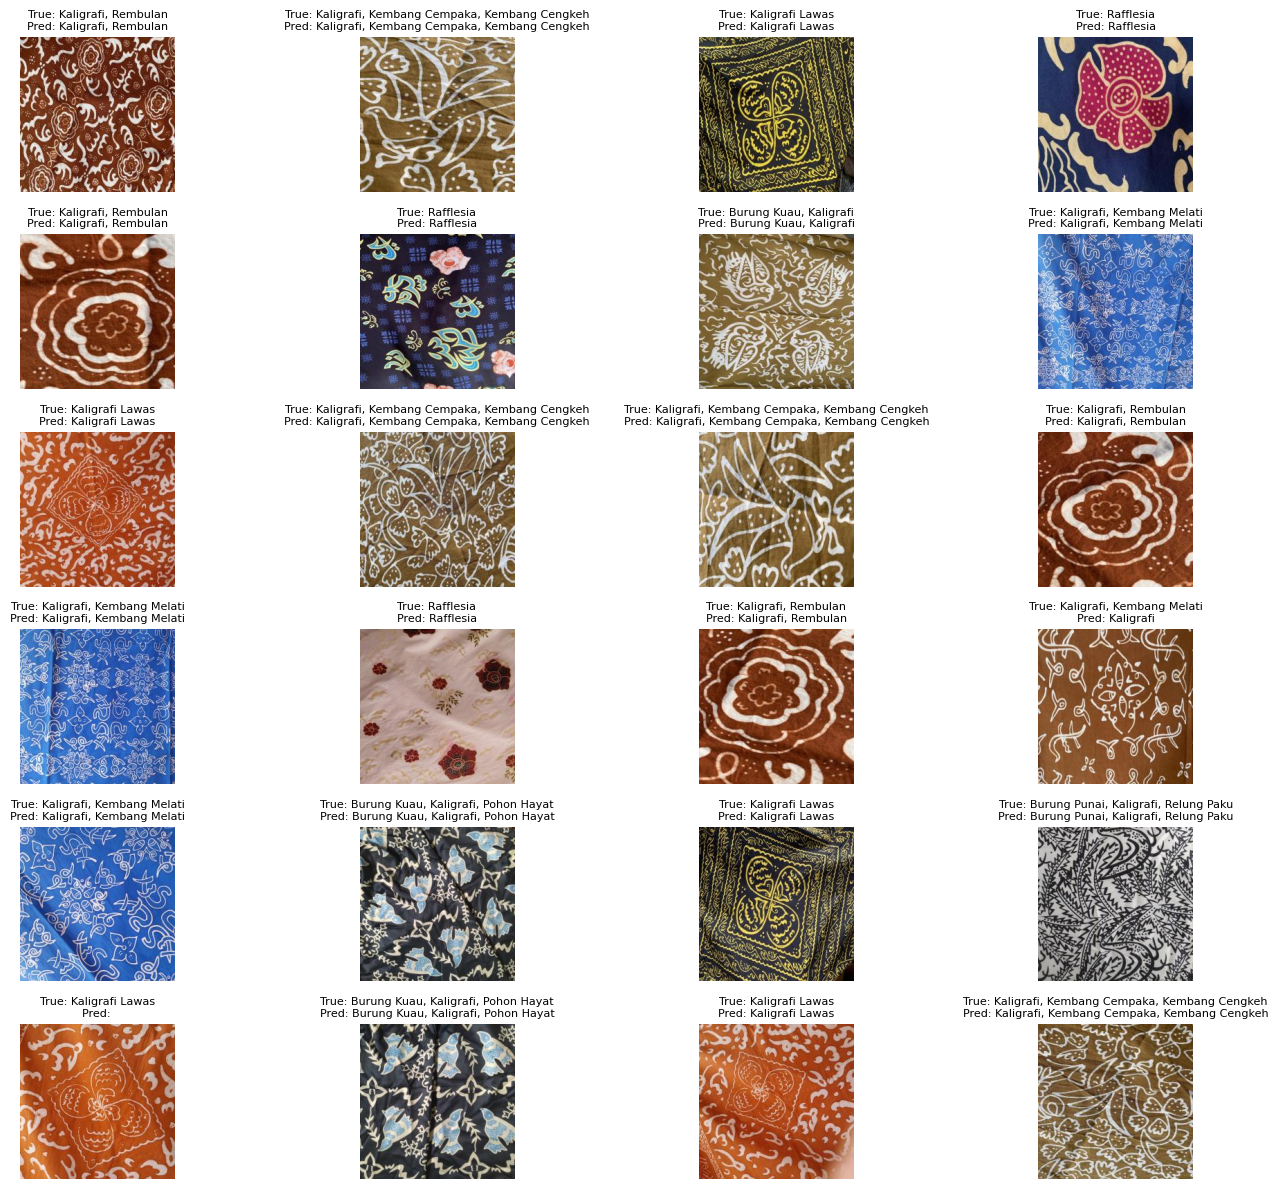

In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Load model
best_model_path = "/content/drive/MyDrive/Dataset/MobileNetV2_3.h5"
model = tf.keras.models.load_model(best_model_path, compile=False)

# Ambil sampel data
num_samples = 24
sample_df = test_df.sample(num_samples, random_state=42)

# Buat plot
fig, axes = plt.subplots(6, 4, figsize=(15, 12))
axes = axes.ravel()

for i, (index, row) in enumerate(sample_df.iterrows()):
    img_path = os.path.join(test_img_folder, row["filename"])

    if os.path.exists(img_path):  # Pastikan file ada
        img = load_img(img_path, target_size=(224, 224))
        img_array = np.expand_dims(img_to_array(img) / 255.0, axis=0)

        # Prediksi
        y_pred_prob = model.predict(img_array, verbose=0)
        y_pred = (y_pred_prob > 0.5).astype(int).flatten()  # Perbaikan di sini
        y_true = row[1:].values.astype(int)

        # Label asli & prediksi
        true_labels = [label for label, t in zip(test_df.columns[1:], y_true) if t == 1]
        pred_labels = [label for label, p in zip(test_df.columns[1:], y_pred) if p == 1]

        # Plot gambar
        axes[i].imshow(img)
        axes[i].axis("off")
        axes[i].set_title(f"True: {', '.join(true_labels)}\nPred: {', '.join(pred_labels)}", fontsize=8)

# Atur tata letak agar lebih rapi
plt.subplots_adjust(hspace=1.0, wspace=0.5)
plt.tight_layout()
plt.show()


### Performa Metrik untuk Valid Data

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, cohen_kappa_score

# Load model yang telah dilatih
model_path = "/content/drive/MyDrive/Dataset/MobileNetV2_3.h5"
model = tf.keras.models.load_model(model_path)


y_true_valid = valid_generator.labels  # Label asli dari valid set
y_pred_probs_valid = model.predict(valid_generator)  # Probabilitas prediksi

# Konversi ke label biner (untuk evaluasi multi-label)
y_pred_valid = (y_pred_probs_valid >= 0.5).astype(int)  # Threshold 0.5

# Menghitung metrik evaluasi
accuracy_valid = accuracy_score(y_true_valid, y_pred_valid)
precision_valid = precision_score(y_true_valid, y_pred_valid, average='macro')
recall_valid = recall_score(y_true_valid, y_pred_valid, average='macro')
f1_valid = f1_score(y_true_valid, y_pred_valid, average='macro')
auc_valid = roc_auc_score(y_true_valid, y_pred_probs_valid, average='macro')
kappa_valid = cohen_kappa_score(y_true_valid.argmax(axis=1), y_pred_valid.argmax(axis=1))

# **Menghitung Final Score sebagai rata-rata dari F1-score, Kappa, dan AUC**
final_score_valid = np.mean([f1_valid, kappa_valid, auc_valid])

# Membuat tabel hasil evaluasi untuk validasi set
metrics_valid = {
    "Accuracy": [accuracy_valid],
    "Precision": [precision_valid],
    "Recall": [recall_valid],
    "AUC": [auc_valid],
    "Kappa": [kappa_valid],
    "F1_score": [f1_valid],
    "Final_score": [final_score_valid]  # Final score dari rata-rata F1-score, Kappa, dan AUC
}


df_valid = pd.DataFrame(metrics_valid)
print("\n=== Model Performance on Validation Set ===")
print(df_valid)

# **Visualisasi bar plot
plt.figure(figsize=(10, 5))
bars = plt.bar(df_valid.columns, df_valid.loc[0], color='cornflowerblue')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2,
             yval + 0.05,
             f"{yval:.2f}",
             ha='center',
             fontsize=10,
             fontweight='bold')

plt.xlabel("Metrics")
plt.ylabel("Score")
plt.title("Validation Set Performance Metrics")
plt.ylim(0, 1.2)  # **Batas atas diperbesar agar ada ruang untuk teks**
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)  # **Menambah grid horizontal untuk estetika**
plt.show()


### Performa Metrik Untuk Test Data

In [ ]:
# Pastikan test_generator sudah dibuat sebelumnya
y_true_test = test_generator.labels  # Label asli dari test set
y_pred_probs_test = model.predict(test_generator)  # Probabilitas prediksi

# Konversi ke label biner (untuk evaluasi multi-label)
y_pred_test = (y_pred_probs_test >= 0.5).astype(int)  # Threshold 0.5

# Menghitung metrik evaluasi
accuracy_test = accuracy_score(y_true_test, y_pred_test)
precision_test = precision_score(y_true_test, y_pred_test, average='macro')
recall_test = recall_score(y_true_test, y_pred_test, average='macro')
f1_test = f1_score(y_true_test, y_pred_test, average='macro')
auc_test = roc_auc_score(y_true_test, y_pred_probs_test, average='macro')
kappa_test = cohen_kappa_score(y_true_test.argmax(axis=1), y_pred_test.argmax(axis=1))

# **Menghitung Final Score sebagai rata-rata semua metrik**
final_score_test = np.mean([f1_test, kappa_test, auc_test])

# Membuat tabel hasil evaluasi untuk test set
metrics_test = {
    "Accuracy": [accuracy_test],
    "Precision": [precision_test],
    "Recall": [recall_test],
    "AUC": [auc_test],
    "Kappa": [kappa_test],
    "F1_score": [f1_test],
    "Final_score": [final_score_test]  # Final score dari rata-rata F1-score, Kappa, dan AUC
}

df_test = pd.DataFrame(metrics_test)
print("\n=== Model Performance on Test Set ===")
print(df_test)

# **Visualisasi bar plot dengan nilai metrik di atas batang (jarak lebih rapi)**
plt.figure(figsize=(10, 5))
bars = plt.bar(df_test.columns, df_test.loc[0], color='salmon')

# Menambahkan nilai di atas setiap batang dengan jarak lebih rapi
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2,
             yval + 0.05,  # **Menambah jarak dari batang agar lebih rapi**
             f"{yval:.2f}",
             ha='center',
             fontsize=10,
             fontweight='bold')

plt.xlabel("Metrics")
plt.ylabel("Score")
plt.title("Test Set Performance Metrics")
plt.ylim(0, 1.2)  # **Batas atas diperbesar agar ada ruang untuk teks**
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)  # **Menambah grid horizontal untuk estetika**
plt.show()


# **Prediksi dengan Interface**

In [ ]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.3/51.3 MB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.2/322.2 kB 23.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 111.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 6.3 MB/s eta 0:00:00


In [ ]:
import gradio as gr
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Load model
best_model_path = "/content/drive/MyDrive/Dataset/MobileNetV2_3.h5"
model = tf.keras.models.load_model(best_model_path, compile=False)

# Label kategori
labels = ['Burung Kuau', 'Burung Punai', 'Kaligrafi', 'Kaligrafi Lawas', 'Kembang Cempaka',
          'Kembang Cengkeh', 'Kembang Melati', 'Pohon Hayat', 'Rafflesia', 'Relung Paku', 'Rembulan']

# Fungsi prediksi
def predict(image):
    img = image.resize((224, 224))  # Resize gambar
    img_array = np.expand_dims(img_to_array(img) / 255.0, axis=0)  # Normalisasi

    y_pred_prob = model.predict(img_array, verbose=0)
    y_pred = (y_pred_prob > 0.5).astype(int).flatten()

    pred_labels = [label for label, p in zip(labels, y_pred) if p == 1]
    return ', '.join(pred_labels) if pred_labels else "Tidak terdeteksi"

# Setup Gradio
iface = gr.Interface(
    fn=predict,
    inputs=gr.Image(type="pil"),
    outputs=gr.Textbox(label="Hasil Prediksi"),
    title="Klasifikasi Motif Batik Besurek",
    description="Upload gambar batik besurek, lalu lihat hasil prediksi model!"
)

# Jalankan aplikasi
iface.launch()

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://9c0bcaea46eca15beb.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


# **Prediksi dengan Input Data Internet**

In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from google.colab import files
import IPython.display as display
from PIL import Image

# Load model
best_model_path = "/content/drive/MyDrive/Dataset/MobileNetV2_3.h5"
model = tf.keras.models.load_model(best_model_path, compile=False)

# Label kategori
labels = ['Burung Kuau', 'Burung Punai', 'Kaligrafi', 'Kaligrafi Lawas', 'Kembang Cempaka',
          'Kembang Cengkeh', 'Kembang Melati', 'Pohon Hayat', 'Rafflesia', 'Relung Paku', 'Rembulan']

# Fungsi prediksi
def predict(image_path):
    img = load_img(image_path, target_size=(224, 224))  # Resize gambar
    img_array = np.expand_dims(img_to_array(img) / 255.0, axis=0)  # Normalisasi

    y_pred_prob = model.predict(img_array, verbose=0)
    y_pred = (y_pred_prob > 0.5).astype(int).flatten()

    pred_labels = [label for label, p in zip(labels, y_pred) if p == 1]
    return ', '.join(pred_labels) if pred_labels else "Tidak terdeteksi"

# Loop untuk upload & prediksi
while True:
    print("\nSilakan upload gambar untuk prediksi:")
    uploaded = files.upload()

    if uploaded:
        image_path = list(uploaded.keys())[0]
        img = Image.open(image_path)

        # Tampilkan gambar
        display.display(img)

        # Prediksi
        hasil_prediksi = predict(image_path)
        print("\n=== Hasil Prediksi ===")
        print(hasil_prediksi)

    # Tanya apakah ingin upload lagi
    lanjut = input("\nIngin upload gambar lain? (ya/tidak): ").strip().lower()
    if lanjut != "ya":
        print("\nTerima kasih! Selesai.")
        break



Silakan upload gambar untuk prediksi:



Ingin upload gambar lain? (ya/tidak): tidak

Terima kasih! Selesai.
